In [ ]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

Min: 239
Avg: 25815
Max: 104905


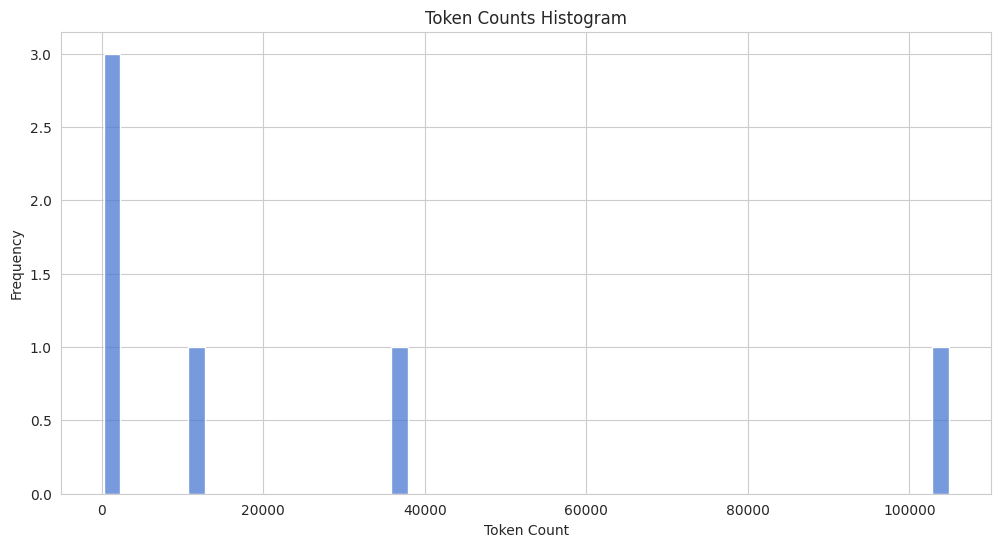

In [1]:
import os
import tiktoken

# Define the directory containing your .txt files
txt_directory = 'data_train'

# Function to read text file
def read_text_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()

# Loading text content from txt files
docs = []
for file in os.listdir(txt_directory):
    if file.endswith('.txt'):
        file_path = os.path.join(txt_directory, file)
        text_content = read_text_file(file_path)
        docs.append({'page_content': text_content, 'metadata': {'source': file_path}})

# Initialize the tiktoken tokenizer
tokenizer = tiktoken.get_encoding('cl100k_base')

# Function to count tokens
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

# Count tokens for each document
token_counts = [tiktoken_len(doc['page_content']) for doc in docs]

# Print min, average, and max token counts
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()


In [89]:
docs[0]

{'page_content': '\ufeffFaculty of Engineering and Applied Science\n4.1 Program of Study\n1. Courses in the Engineering Program are normally taken in Academic Terms as shown in the appropriate program table. Students must satisfy the criteria for promotion as described below under Promotion Regulations to remain in the Engineering program.\n\n2. The Engineering Program consists of eight academic terms and four to six work terms. The first-year of the Engineering Program, known as Engineering One, forms a core that is common to all majors. All students must successfully complete the requirements of Engineering One prior to being promoted to Academic Term 3 as indicated under Promotion Regulations, Promotion Status (Engineering One).\n\n3. To be eligible for registration for ENGI 001W in the Spring semester after completing Engineering One, students are expected to successfully complete the prerequisite ENGI 200W in the Fall semester of Engineering One. All other Engineering One students

We access the plaintext page content like so:

In [3]:
print(docs[0]['page_content'])

Faculty of Engineering and Applied Science
4.1 Program of Study
1. Courses in the Engineering Program are normally taken in Academic Terms as shown in the appropriate program table. Students must satisfy the criteria for promotion as described below under Promotion Regulations to remain in the Engineering program.

2. The Engineering Program consists of eight academic terms and four to six work terms. The first-year of the Engineering Program, known as Engineering One, forms a core that is common to all majors. All students must successfully complete the requirements of Engineering One prior to being promoted to Academic Term 3 as indicated under Promotion Regulations, Promotion Status (Engineering One).

3. To be eligible for registration for ENGI 001W in the Spring semester after completing Engineering One, students are expected to successfully complete the prerequisite ENGI 200W in the Fall semester of Engineering One. All other Engineering One students are expected to successfully 

In [39]:
docs[5]

{'page_content': "Question: Can you tell me about the advanced topics in Physics 3050?\nAnswer: Physics 3050 delves into quantum mechanics, covering concepts like wave-particle duality, quantum states, and uncertainty principles. It's a challenging but rewarding course, especially if you're interested in modern physics theories. Would you like more specifics on any topic, or information on related courses?\n\nQuestion: What skills can I expect to develop in Business 1010?\nAnswer: In Business 1010, you'll develop foundational skills in business management, including basic accounting, marketing, and strategic planning. It's a great course to start building your business acumen. Are there particular business skills you're looking to enhance?\n\nQuestion: Is there a focus on practical experiments in Physics 2020?\nAnswer: Absolutely, Physics 2020 heavily emphasizes practical experiments. You'll get hands-on experience in the lab, which is crucial for understanding theoretical concepts in 

We can also find the source of each document:

In [5]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [14]:
token_counts = [tiktoken_len(doc['page_content']) for doc in docs]

In [34]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [35]:
for doc in docs:
    chunks = text_splitter.split_text(doc['page_content'])
    print(f"Document: {doc['metadata']['source']} - Number of Chunks: {len(chunks)}")


Document: data_train/Faculty of Engineering and Applied Science.txt - Number of Chunks: 75
Document: data_train/Faculty of Science.txt - Number of Chunks: 212
Document: data_train/AI_Academic_Advisor_Knowledge_Base.txt - Number of Chunks: 2
Document: data_train/abbreviations_train.txt - Number of Chunks: 1
Document: data_train/Faculty of Business Administration.txt - Number of Chunks: 27
Document: data_train/Detailed_AI_Academic_Advisor_Knowledge_Base.txt - Number of Chunks: 2


In [37]:
tiktoken_len(chunks[1])

63

In [40]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5]['metadata']['source'].replace('data_train/', 'https://www.mun.ca/university-calendar/')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

https://www.mun.ca/university-calendar/Detailed_AI_Academic_Advisor_Knowledge_Base.txt
8998c52d5cc7


In [41]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data

[{'id': '8998c52d5cc7-0',
  'text': "Question: Can you tell me about the advanced topics in Physics 3050?\nAnswer: Physics 3050 delves into quantum mechanics, covering concepts like wave-particle duality, quantum states, and uncertainty principles. It's a challenging but rewarding course, especially if you're interested in modern physics theories. Would you like more specifics on any topic, or information on related courses?\n\nQuestion: What skills can I expect to develop in Business 1010?\nAnswer: In Business 1010, you'll develop foundational skills in business management, including basic accounting, marketing, and strategic planning. It's a great course to start building your business acumen. Are there particular business skills you're looking to enhance?\n\nQuestion: Is there a focus on practical experiments in Physics 2020?\nAnswer: Absolutely, Physics 2020 heavily emphasizes practical experiments. You'll get hands-on experience in the lab, which is crucial for understanding theor

In [43]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc['metadata']['source'].replace('data_train/', 'https://www.mun.ca/')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc['page_content'])
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

100%|██████████| 6/6 [00:00<00:00, 15.49it/s]


319

In [44]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

In [45]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

319

In [46]:
documents[0]

{'id': '00bb7cb162b1-0',
 'text': '\ufeffFaculty of Engineering and Applied Science\n4.1 Program of Study\n1. Courses in the Engineering Program are normally taken in Academic Terms as shown in the appropriate program table. Students must satisfy the criteria for promotion as described below under Promotion Regulations to remain in the Engineering program.\n\n2. The Engineering Program consists of eight academic terms and four to six work terms. The first-year of the Engineering Program, known as Engineering One, forms a core that is common to all majors. All students must successfully complete the requirements of Engineering One prior to being promoted to Academic Term 3 as indicated under Promotion Regulations, Promotion Status (Engineering One).\n\n3. To be eligible for registration for ENGI 001W in the Spring semester after completing Engineering One, students are expected to successfully complete the prerequisite ENGI 200W in the Fall semester of Engineering One. All other Enginee

# Import the dataset

In [50]:
from datasets import load_dataset

data=load_dataset('bibrahim/rag_tryout', split='train')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1127.80it/s]
                                                        

Dataset json downloaded and prepared to /home/nurul/.cache/huggingface/datasets/bibrahim___json/bibrahim--rag_tryout-9e32671c097e1553/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


In [51]:
data[0]

{'id': '00bb7cb162b1-0',
 'text': '\ufeffFaculty of Engineering and Applied Science\n4.1 Program of Study\n1. Courses in the Engineering Program are normally taken in Academic Terms as shown in the appropriate program table. Students must satisfy the criteria for promotion as described below under Promotion Regulations to remain in the Engineering program.\n\n2. The Engineering Program consists of eight academic terms and four to six work terms. The first-year of the Engineering Program, known as Engineering One, forms a core that is common to all majors. All students must successfully complete the requirements of Engineering One prior to being promoted to Academic Term 3 as indicated under Promotion Regulations, Promotion Status (Engineering One).\n\n3. To be eligible for registration for ENGI 001W in the Spring semester after completing Engineering One, students are expected to successfully complete the prerequisite ENGI 200W in the Fall semester of Engineering One. All other Enginee

In [53]:
from getpass import getpass
OPENAI_API_KEY = getpass('Enter your OpenAI API key: ')

In [57]:
data = data.to_pandas()

In [56]:
data.head()

,id,text,source
0,00bb7cb162b1-0,﻿Faculty of Engineering and Applied Science\n4...,https://www.mun.ca/Faculty of Engineering and ...
1,00bb7cb162b1-1,Some of the courses offered in academic terms ...,https://www.mun.ca/Faculty of Engineering and ...
2,00bb7cb162b1-2,2. Applicants who have not successfully comple...,https://www.mun.ca/Faculty of Engineering and ...
3,00bb7cb162b1-3,Work terms shall normally be taken in the orde...,https://www.mun.ca/Faculty of Engineering and ...
4,00bb7cb162b1-4,**Winter - Academic Term 8** -\n - Required...,https://www.mun.ca/Faculty of Engineering and ...


In [58]:
from getpass import getpass
from langchain.embeddings.openai import OpenAIEmbeddings

model_name = 'text-embedding-ada-002'

embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

In [2]:
import pinecone
from getpass import getpass
# find API key in console at app.pinecone.io
YOUR_API_KEY = getpass("Pinecone API Key: ")
# find ENV (cloud region) next to API key in console
YOUR_ENV = input("Pinecone environment: ")

index_name = 'langchain-retrieval-agent'
pinecone.init(
    api_key=YOUR_API_KEY,
    environment=YOUR_ENV
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='dotproduct',
        dimension=1536  # 1536 dim of text-embedding-ada-002
    )

/home/nurul/venvs/tfgpu_mans/lib/python3.10/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


TypeError: expected string or bytes-like object

In [60]:
index = pinecone.GRPCIndex(index_name)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

In [62]:
from tqdm.auto import tqdm
from uuid import uuid4

batch_size = 100

texts = []
metadatas = []

for i in tqdm(range(0, len(data), batch_size)):
    # get end of batch
    i_end = min(len(data), i+batch_size)
    batch = data.iloc[i:i_end]
    # first get metadata fields for this record
    metadatas = [{
        'text': record['text']
    } for j, record in batch.iterrows()]
    # get the list of contexts / documents
    documents = batch['text']
    # create document embeddings
    embeds = embed.embed_documents(documents)
    # get IDs
    ids = batch['id']
    # add everything to pinecone
    index.upsert(vectors=zip(ids, embeds, metadatas))

100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


In [63]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.00319,
 'namespaces': {'': {'vector_count': 319}},
 'total_vector_count': 319}

In [79]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embed.embed_query, text_field
)

In [95]:
query = "what courses should I take for term 4 electrical engineering"

vectorstore.similarity_search(
    query,  # our search query
    k=10  # return 3 most relevant docs
)

[Document(page_content='Work terms shall normally be taken in the order as set out in Civil Engineering Major.\n\n\n\n**Engineering One Term** -\n   - Required Courses:\n     1. Chemistry 1050 or 1200\n     2. 3 credit hours in English at the 1000 level or any Critical Reading and Writing course\n     3. Mathematics 1000, 1001, 2050\n     4. Physics 1050, 1051\n   - Elective Courses:\n     1. ENGI 1010, 1020, 1030, 1040\n\n\n**Fall - Academic Term 3** -\n   - Required Courses:\n     1. CIV 3210, 3440, 3710, 3720\n   - Elective Courses:\n     1. ENGI 3101\n     2. Mechanical and Mechatronics Engineering 3301\n\n\n**Winter** -\n   - Required Courses:\n     1. ENGI 001W or 002W\n\n\n**Spring - Academic Term 4** -\n   - Required Courses:\n     1. CIV 4220, 4310, 4450, 4610\n   - Elective Courses:\n     1. ENGI 4421\n\n\n**Fall** -\n   - Required Courses:\n     1. ENGI 001W or 002W or 003W\n\n\n**Winter - Academic Term 5** -\n   - Required Courses:\n     1. CIV 5110, 5230, 5320, 5460, 5510\

In [97]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.chains import RetrievalQA

# chat completion llm
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-4-1106-preview',
    temperature=0.2
)
# conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=15,
    return_messages=True
)
# retrieval qa chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [98]:
qa.run(query)

'For Term 4 in Electrical Engineering, according to the provided context, you should take the following required courses:\n\n- ECE 4300\n- ECE 4500\n- ECE 4600\n- ECE 4800\n\nAdditionally, you have an elective course:\n\n- ENGI 4430\n\nMake sure to check with your academic advisor or the latest curriculum provided by your university to confirm these courses and any potential changes that may have occurred after the knowledge cutoff date.'

In [99]:
from langchain.agents import Tool

tools = [
    Tool(
        name='Knowledge Base',
        func=qa.run,
        description=(
            'use this tool when answering general knowledge queries to get '
            'more information about the topic'
        )
    )
]

In [100]:
from langchain.agents import initialize_agent

agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=5,
    early_stopping_method='generate',
    memory=conversational_memory
)

### Using the Conversational Agent

In [101]:
agent(query)



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "term 4 electrical engineering course requirements"
}
```
Observation: In Term 4 for Electrical Engineering, the required courses are as follows:

- ECE 4300
- ECE 4500
- ECE 4600
- ECE 4800
- ENGI 4430

Please note that these are the required courses for Term 4 specifically within the context provided. If you are looking for information from a different term or a different context, please provide additional details.
Thought:```json
{
    "action": "Final Answer",
    "action_input": "The required courses for Term 4 in Electrical Engineering typically include ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430. Please consult your academic advisor or your university's official curriculum to ensure you are taking the correct courses, as requirements can vary by institution and may be subject to change."
}
```

> Finished chain.


{'input': 'what courses should I take for term 4 electrical engineering',
 'chat_history': [],
 'output': "The required courses for Term 4 in Electrical Engineering typically include ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430. Please consult your academic advisor or your university's official curriculum to ensure you are taking the correct courses, as requirements can vary by institution and may be subject to change."}

In [102]:
agent("Tell me about these courses in detail")



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "ECE 4300 course details, ECE 4500 course details, ECE 4600 course details, ECE 4800 course details, ENGI 4430 course details"
}
```
Observation: Based on the provided context, here are the details for the courses ECE 4300, ECE 4500, and ECE 4600. Unfortunately, there are no details provided for ECE 4800 and ENGI 4430, which suggests that they might be inactive courses or simply not included in the provided context.

**ECE 4300:**
Unfortunately, there are no details provided for ECE 4300 in the provided context. However, it is referenced as a prerequisite for ECE 5300, which suggests it is likely a course related to electronic circuits, as ECE 5300 is "Electronic Circuits II."

**ECE 4500:**
ECE 4500 is not directly described in the provided context. However, it is mentioned as a prerequisite for ECE 5500, which is "Digital Systems." This implies that ECE 4500 may be an introductory co

{'input': 'Tell me about these courses in detail',
 'chat_history': [HumanMessage(content='what courses should I take for term 4 electrical engineering', additional_kwargs={}, example=False),
  AIMessage(content="The required courses for Term 4 in Electrical Engineering typically include ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430. Please consult your academic advisor or your university's official curriculum to ensure you are taking the correct courses, as requirements can vary by institution and may be subject to change.", additional_kwargs={}, example=False)],
 'output': 'The specific details for the courses ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430 are not available based on the provided context. For ECE 4300, while there are no direct details, it is referenced as a prerequisite for a course on electronic circuits, suggesting it may cover related foundational topics. ECE 4500 is mentioned as a prerequisite for a course on digital systems, indicating it might be

In [103]:
agent("Tell me about ECE 4300")



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "ECE 4300 course description"
}
```
Observation: I'm sorry, but the course description for ECE 4300 is not provided in the context given. If you need information about ECE 4300, you may want to contact the relevant department or academic advisor for the most accurate and up-to-date course information.
Thought:```json
{
    "action": "Final Answer",
    "action_input": "For detailed information about the ECE 4300 course, it is recommended to contact the relevant department or academic advisor at your educational institution. They will be able to provide the most accurate and up-to-date course descriptions, prerequisites, and any other information you may need."
}
```

> Finished chain.


{'input': 'Tell me about ECE 4300',
 'chat_history': [HumanMessage(content='what courses should I take for term 4 electrical engineering', additional_kwargs={}, example=False),
  AIMessage(content="The required courses for Term 4 in Electrical Engineering typically include ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430. Please consult your academic advisor or your university's official curriculum to ensure you are taking the correct courses, as requirements can vary by institution and may be subject to change.", additional_kwargs={}, example=False),
  HumanMessage(content='Tell me about these courses in detail', additional_kwargs={}, example=False),
  AIMessage(content='The specific details for the courses ECE 4300, ECE 4500, ECE 4600, ECE 4800, and ENGI 4430 are not available based on the provided context. For ECE 4300, while there are no direct details, it is referenced as a prerequisite for a course on electronic circuits, suggesting it may cover related foundational topics. 

In [1]:
pinecone.delete_index(index_name)

NameError: name 'pinecone' is not defined